# Variation due to `word2vec`'s random initialisation

 - fairly small at the word analogy task

In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
from gui.output_utils import *
from gui.user_code import pretty_names

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


In [2]:
def get_exp_ids_for_reruns_of_word2vec(corpus='amazon_grouped-tagged', rep=0):
    query_dict = {
        'expansions__use_similarity': 0, 
          'expansions__neighbour_strategy':'linear',
          'expansions__vectors__dimensionality': 100, 
          'document_features_ev': 'AN+NN', 
          'document_features_tr': 'J+N+AN+NN', 
          'expansions__allow_overlap': False,
          'expansions__entries_of': None,
          'expansions__vectors__algorithm': 'word2vec',
          'expansions__vectors__composer__in': ['Add', 'Mult', 'Left', 'Right'], # todo Verb???
          'expansions__vectors__unlabelled': 'wiki',
          'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
          'expansions__noise': 0,
          'expansions__use_similarity': 0, 
          'expansions__k':3,
          'expansions__vectors__unlabelled_percentage': 15,
          'expansions__vectors__rep': rep,
          'labelled':corpus}
    return Experiment.objects.filter(**query_dict).values_list('id', flat=True)

[[87, 88, 89, 90], [91, 92, 93, 94], [95, 96, 97, 98], [83, 84, 85, 86]]
['0', '1', '2', 'avg']


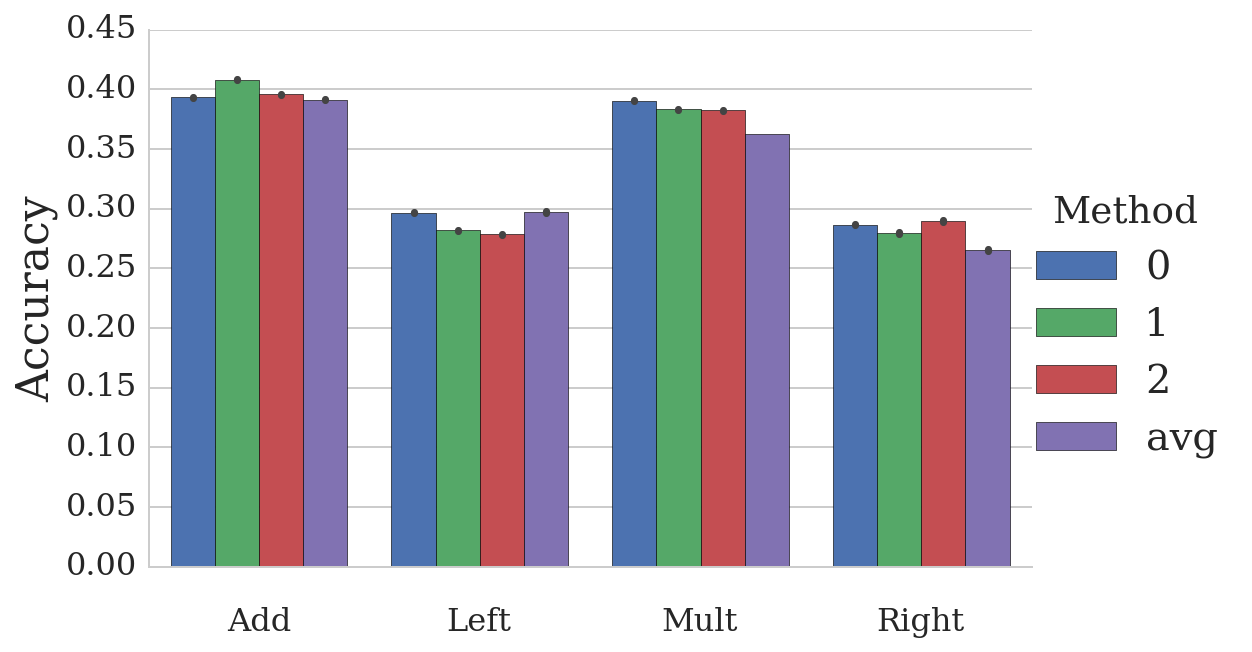

In [3]:
ids = [get_exp_ids_for_reruns_of_word2vec(rep=r) for r in [0, 1, 2, -1]]
print(ids)    
hue_order = pretty_names([x[0] for x in ids], 
                    name_format=['expansions__vectors__rep'])
hue_order[-1] = 'avg'
print(hue_order)
composers = pretty_names(ids[0], 
                    name_format=['expansions__vectors__composer'])

diff_plot_bar(ids, hue_order, composers, hue_order=hue_order)
plt.savefig('plot-w2v_random_init_var.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Compare unigram vectors between multiple runs
How many of the top `n` neighbour of some entries are the same accross multiple runs

In [8]:
from glob import glob
from discoutils.thesaurus_loader import Vectors as V
from random import sample
from itertools import combinations

pattern = '/mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-15perc.unigr.strings.*'
files = sorted(glob(pattern))
thes = [V.from_tsv(f) for f in files]

In [9]:
def dice(n1, n2):
    return 2 * len(set(n1) & set(n2))/ (len(n1) + len(n2))

for t in thes:
    t.init_sims(n_neighbors=30)

sampled_words = sample(list(thes[0].keys()), 500)

dice_data = []
for i,j in combinations(range(len(thes)), 2):
    pair_id = '%d-%r'%(i,j if j < 3 else 'A')
    print('Doing pair', pair_id, flush=True)
    for num, word in enumerate(sampled_words):
        n1 = [x[0] for x in thes[i].get_nearest_neighbours(word)]
        n2 = [x[0] for x in thes[j].get_nearest_neighbours(word)]
        dice_data.append([pair_id, word, dice(n1, n2)])

Doing pair 0-1
Doing pair 0-2
Doing pair 0-'A'
Doing pair 1-2
Doing pair 1-'A'
Doing pair 2-'A'


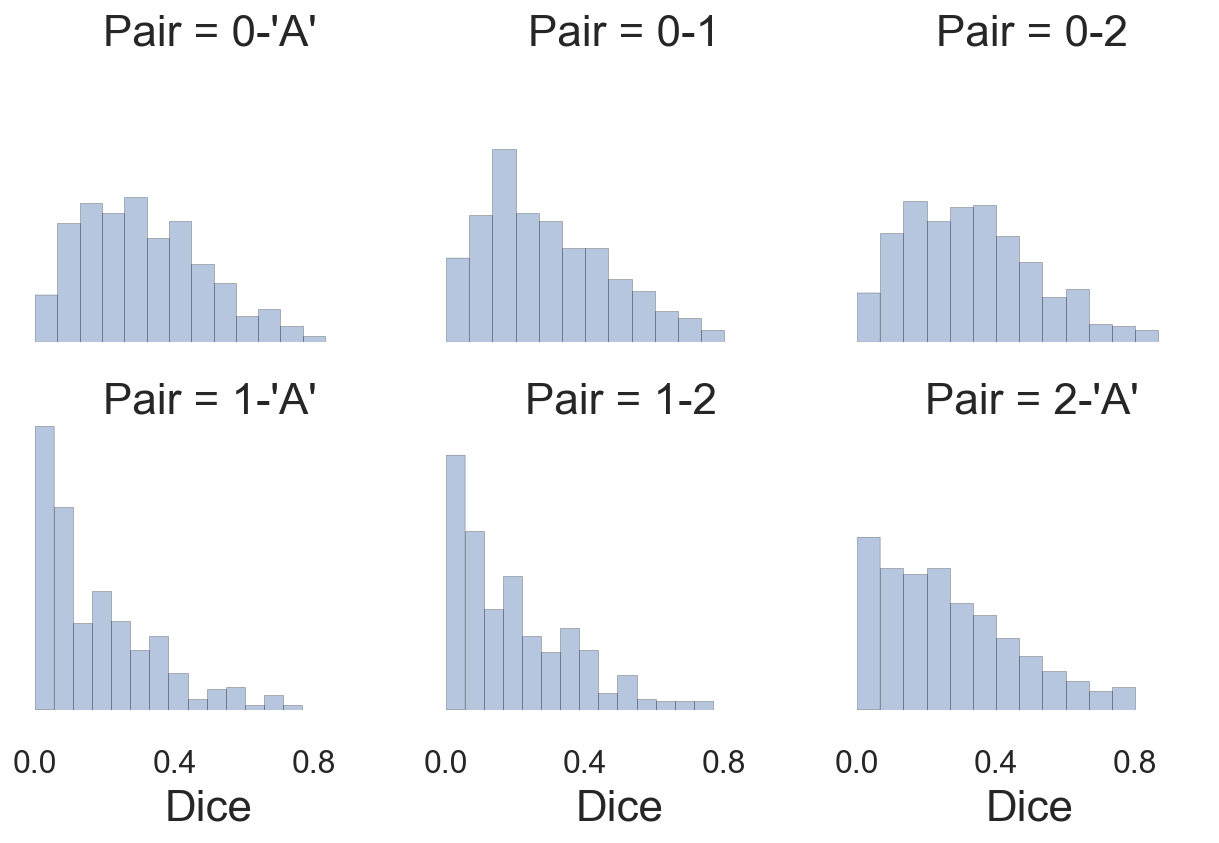

In [11]:
df3 = pd.DataFrame(dice_data, columns='Pair Word Dice'.split())
with sns.axes_style("white"):
    g = sns.FacetGrid(df3, col="Pair", col_wrap=3);
    g.map(sns.distplot, 'Dice', kde=False);

for ax in g.axes.flat:
    sparsify_axis_labels(ax)
    ax.set_xlim(0, 1)
    ax.set_yticklabels([])

sns.despine(left=True, bottom=True)
plt.savefig('plot-w2v_random_init_neigh_overlap.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Observations
Neighbours tend to be quite different over multiple runs, but the overall accuracy of the classification task changes very little